In [1]:
import os
from dotenv import load_dotenv
import pandas as pd
import mysql.connector


# .env 파일 로드
load_dotenv()

# 환경 변수 읽기
DB_HOST = os.getenv("DB_HOST")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_NAME = os.getenv("DB_NAME")
DB_SUER = os.getenv("DB_USER")

In [2]:
conn = mysql.connector.connect(
    host = DB_HOST,
    user = DB_SUER,
    password = DB_PASSWORD,
    database = DB_NAME
)   

cursor = conn.cursor(buffered=True)

# SQL 쿼리 실행 및 데이터 불러오기
query = """
SELECT report_date, cold_injury FROM michelin.naver_trend_day
WHERE report_date BETWEEN '2019-01-01' AND '2024-12-31';
"""
df = pd.read_sql(query, conn)

# 연결 종료
conn.close()

df['report_date'] = pd.to_datetime(df['report_date'])  # 날짜 형식 변환
df['report_date'] = df['report_date'].dt.to_period('M')  # 년-월 추출


numeric_columns = df.select_dtypes(include=['number']).columns

ndf = df.groupby('report_date')[numeric_columns].sum()

print(ndf)

             cold_injury
report_date             
2019-01         91.24841
2019-02         42.88931
2019-03          8.56197
2019-04          5.85347
2019-05          2.97656
...                  ...
2024-01         61.36514
2024-02         22.28868
2024-03         15.29382
2024-04          4.43342
2024-05          4.03369

[65 rows x 1 columns]


/tmp/ipykernel_23601/3760699316.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [3]:
conn = mysql.connector.connect(
    host = DB_HOST,
    user = DB_SUER,
    password = DB_PASSWORD,
    database = DB_NAME
)   

cursor = conn.cursor(buffered=True)

# SQL 쿼리 실행 및 데이터 불러오기
query = """
SELECT DATE_FORMAT(report_date, '%Y-%m') as report_date, patient_count as patient_count FROM michelin.disease_age where age_group_10 = "계" and category = "한랭질환 ";
"""
pdf = pd.read_sql(query, conn)
pdf.set_index("report_date", inplace=True)
pdf
# 연결 종료
conn.close()

/tmp/ipykernel_23601/1138076177.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pdf = pd.read_sql(query, conn)


In [30]:
print(pdf)

             patient_count
report_date               
2019-01               5510
2019-02               2882
2019-03               1302
2019-04                722
2019-05                442
...                    ...
2022-10                371
2022-11                588
2022-12               6697
2023-01               5847
2023-02               4516

[65 rows x 1 columns]


In [29]:
print(ndf)

             cold_injury
report_date             
2019-01      5776.909450
2019-02      2768.842525
2019-03       633.589055
2019-04       465.113023
2019-05       286.161434
...                  ...
2024-01      3918.089164
2024-02      1487.427574
2024-03      1052.328348
2024-04       376.782069
2024-05       351.917781

[65 rows x 1 columns]


In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
ndf['cold_injury'] = scaler.fit_transform(ndf[['cold_injury']])

ndf['cold_injury'] = ndf['cold_injury'] * (pdf['patient_count'].max() - pdf['patient_count'].min()) + pdf['patient_count'].min()

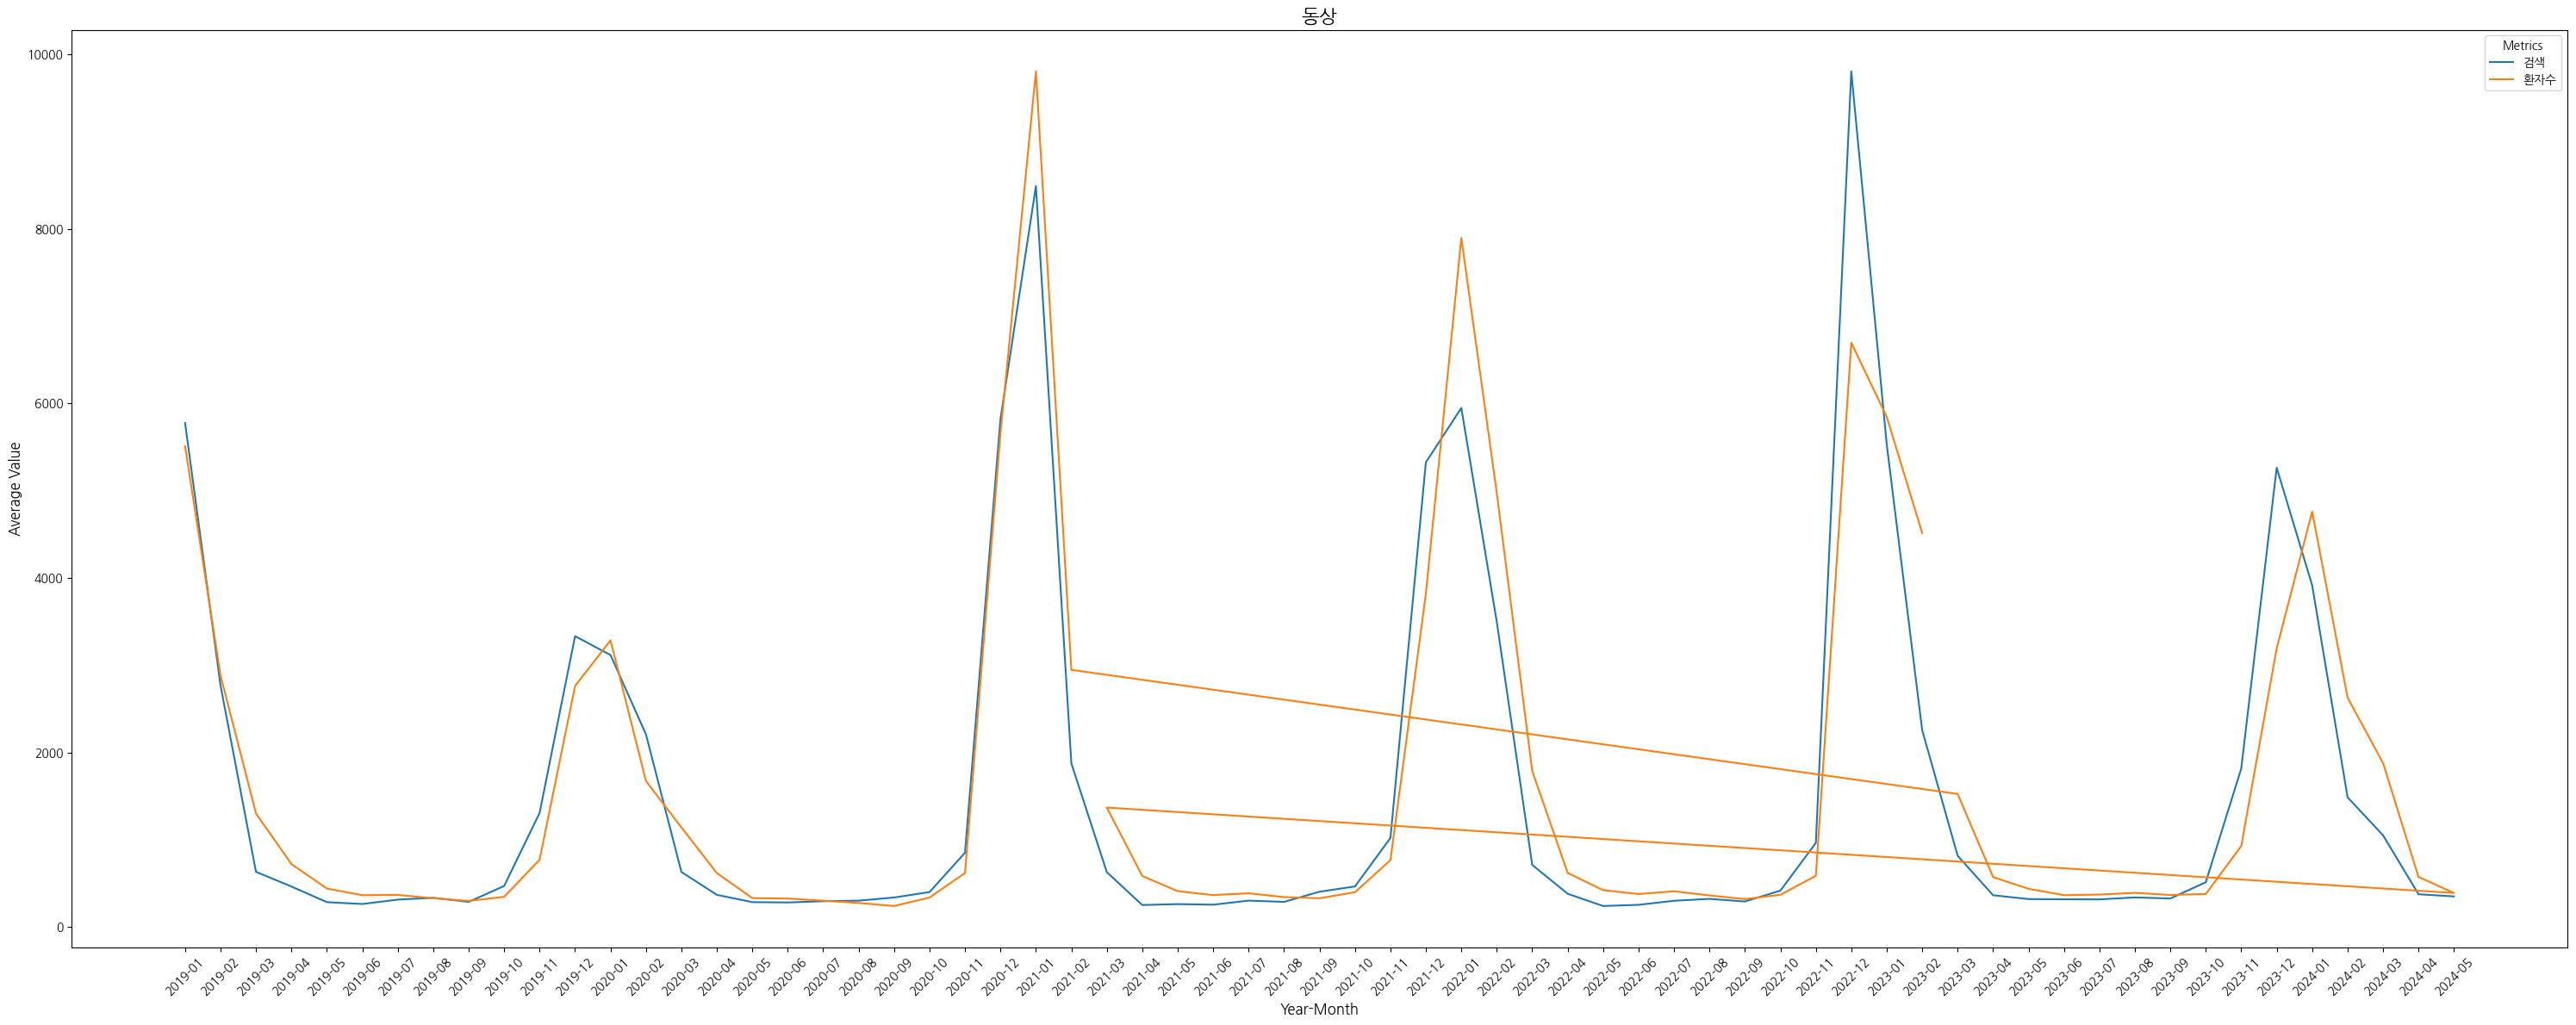

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

plt.figure(figsize=(30, 12))
plt.plot(ndf.index.astype(str), ndf["cold_injury"], label=("검색"))
plt.plot(pdf.index.astype(str), pdf["patient_count"], label=("환자수"))

plt.title("동상", fontsize=16)
plt.xlabel("Year-Month", fontsize=12)
plt.ylabel("Average Value", fontsize=12)
plt.legend(title="Metrics")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
ndf = ndf.reset_index()
pdf

,patient_count
report_date,
2019-01,5510
2019-02,2882
2019-03,1302
2019-04,722
2019-05,442
...,...
2022-10,371
2022-11,588
2022-12,6697


In [9]:
# year_monthly_average
pdf

,patient_count
report_date,
2019-01,5510
2019-02,2882
2019-03,1302
2019-04,722
2019-05,442
...,...
2022-10,371
2022-11,588
2022-12,6697


In [10]:
pdf['report_date'] = pd.to_datetime(pdf['report_date']).dt.to_period('M')

merged_df = pd.merge(ndf, pdf, left_on='report_date', right_on='report_date', how='inner')


# 결측값 제거
merged_df = merged_df.dropna()

# 확인
print(merged_df.head())

KeyError: 'report_date'

  report_date  gastroenteritis  patient_count
0     2019-01      5011.172414        6213.83
1     2019-02      3948.239646        5080.37
2     2019-03      3249.204195        4985.79
3     2019-04      3691.409118        5317.83
4     2019-05      4192.008019        5660.35
                 gastroenteritis  patient_count
gastroenteritis          1.00000        0.62863
patient_count            0.62863        1.00000


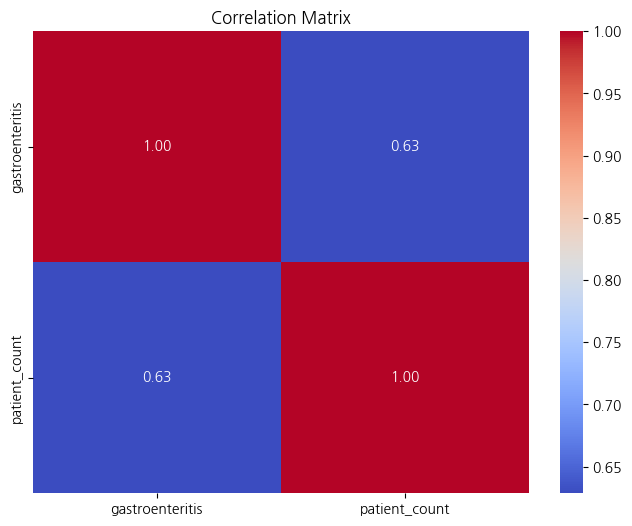

In [274]:
# 두 데이터 병합 (기준: report_date)
merged_df = pd.merge(ndf, pdf, left_on='report_date', right_on='report_date', how='inner')

# 결측값 제거
merged_df = merged_df.dropna()

# 확인
print(merged_df.head())

# 상관 행렬 계산
correlation_matrix = merged_df[['gastroenteritis', 'patient_count']].corr()

# 상관 행렬 출력
print(correlation_matrix)

# 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [212]:
# 열 이름 확인
print(year_monthly_average.columns)  # ['index', 'value1']
print(df.columns)  # ['index', 'value2']

# 병합
merged_df = pd.merge(year_monthly_average, df, on='index', how='inner')

# 결과 확인
print(merged_df)

Index(['gastroenteritis'], dtype='object')
Index(['patient_count'], dtype='object')


KeyError: 'index'

<class 'pandas.core.frame.DataFrame'>
Index: 65 entries, 2019-01 to 2024-05
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   patient_count  65 non-null     float64
dtypes: float64(1)
memory usage: 1.0+ KB


In [180]:
# 인덱스를 열로 변환
year_monthly_average.reset_index(inplace=True)
df.reset_index(inplace=True)

# 열 이름 확인
print(year_monthly_average.columns)  # ['index', 'value1']
print(df.columns)  # ['index', 'value2']

# 병합
merged_df = pd.merge(year_monthly_average, df, on='index', how='inner')

# 결과 확인
print(merged_df)

Index(['year_month', 'allergy', 'shingles', 'hfmd', 'gastroenteritis',
       'food_poisoning', 'cold', 'flu', 'cold_injury'],
      dtype='object')
Index(['report_date', 'patient_count'], dtype='object')


KeyError: 'index'